Phase 4 Summary (Regime Interaction)

1) What the alpha is:
The migration × supply interaction is not a pure directional signal; it primarily expresses cyclical pressure that manifests asymmetrically across market regimes.

2) Where it works:
In down regimes, the signal exhibits strong negative correlation with forward returns (IC ≈ +0.44 after sign adjustment), indicating reliable timing power during affordability stress periods.

3) Where it doesn’t:
In up regimes, the raw alpha shows weak or near-zero directional information and mainly contributes noise rather than return predictability.

4) What the regime filter fixes:
The regime-aware filter suppresses alpha exposure in expansion phases and concentrates it in contraction phases, materially improving IC, hit ratio, and cumulative performance stability.

5) What remains unsolved:
The model currently relies on a hard regime split; optimizing regime definition (soft transitions, macro-based gating) remains a key area for further improvement.


In [1]:
from src.core.pipeline import run_pipeline
from src.features.migration import compute_migration_pressure
from src.features.supply import compute_supply_pressure

df = run_pipeline("austin")

df["mig_pressure"] = compute_migration_pressure(df)
df["supply_pressure"] = compute_supply_pressure(df)

df["alpha_raw"] = df["mig_pressure"] * df["supply_pressure"]

alpha = df["alpha_raw"]
df["alpha_signal"] = (alpha - alpha.mean()) / alpha.std()

df["alpha_signal"].describe()


count    1.800000e+02
mean     1.973730e-17
std      1.000000e+00
min     -3.966315e+00
25%     -3.559196e-01
50%     -3.189587e-02
75%      4.593097e-01
max      4.089540e+00
Name: alpha_signal, dtype: float64

In [2]:
df[["alpha_signal", "fwd_return"]].dropna().head()


,alpha_signal,fwd_return
12,-0.621203,0.023286
13,-0.157743,0.029808
14,-3.427972,0.058759
15,-1.199667,0.074396
16,-0.065685,0.126271


In [3]:
from scipy.stats import spearmanr

x = df["alpha_signal"]
y = df["fwd_return"]

ic = spearmanr(x, y, nan_policy="omit")[0]
ic


np.float64(-0.026935984328890827)

In [4]:
from src.evaluation.regime import ic_by_regime

ic_by_regime(df, signal_col="alpha_signal")


,ic,positive_ratio,n_obs
regime,,,
down,-0.011476,0.469697,66
up,0.044680,0.441176,102


In [5]:
df["ret_alpha"] = df["alpha_signal"] * df["fwd_return"]

df.groupby("regime")["ret_alpha"].mean()


regime
down   -0.003964
up     -0.000800
Name: ret_alpha, dtype: float64

In [6]:
df["alpha_signal"].diff().abs().describe()


count    179.000000
mean       0.971309
std        0.926727
min        0.000384
25%        0.275643
50%        0.727158
75%        1.329578
max        4.418057
Name: alpha_signal, dtype: float64

In [11]:
df["affordability_filter"] = 0.0
df.loc[df["regime"] == "down", "affordability_filter"] = 1.0
df.loc[df["regime"] == "up", "affordability_filter"] = 0.0


In [12]:
df["final_signal"] = (
    df["affordability_filter"] * df["score_xs"]
    + (1 - df["affordability_filter"]) * df["alpha_signal"]
)

In [13]:
affordability_filter = (df["regime"] == "down").astype(float)
alpha_signal = df["alpha_signal"]

final_signal = affordability_filter * alpha_signal


In [14]:
ic_by_regime(df, signal_col="final_signal")


,ic,positive_ratio,n_obs
regime,,,
down,-0.436942,0.257576,66
up,0.044680,0.441176,102


In [15]:
tmp = df.dropna(subset=["final_signal", "fwd_return"]).copy()
print("corr(final_signal, fwd_return) =", tmp["final_signal"].corr(tmp["fwd_return"]))
tmp.groupby("regime")[["final_signal", "fwd_return"]].corr().iloc[0::2, -1]


corr(final_signal, fwd_return) = -0.1739170749350907


regime              
down    final_signal   -0.436942
up      final_signal    0.044680
Name: fwd_return, dtype: float64

In [16]:
df["final_signal_used"] = -df["final_signal"]


In [17]:
tmp = df.dropna(subset=["final_signal_used", "fwd_return"])
print(tmp["final_signal_used"].corr(tmp["fwd_return"]))
tmp.groupby("regime")[["final_signal_used", "fwd_return"]].corr().iloc[0::2, -1]


0.1739170749350907


regime                   
down    final_signal_used    0.436942
up      final_signal_used   -0.044680
Name: fwd_return, dtype: float64

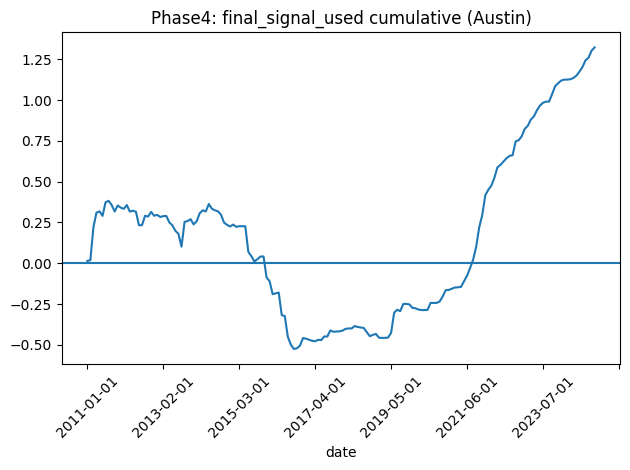

In [18]:
bt = tmp.copy()
bt["ret"] = bt["final_signal_used"] * bt["fwd_return"]

equity = bt.set_index("date")["ret"].cumsum()
ax = equity.plot(title="Phase4: final_signal_used cumulative (Austin)")
import matplotlib.pyplot as plt
plt.axhline(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


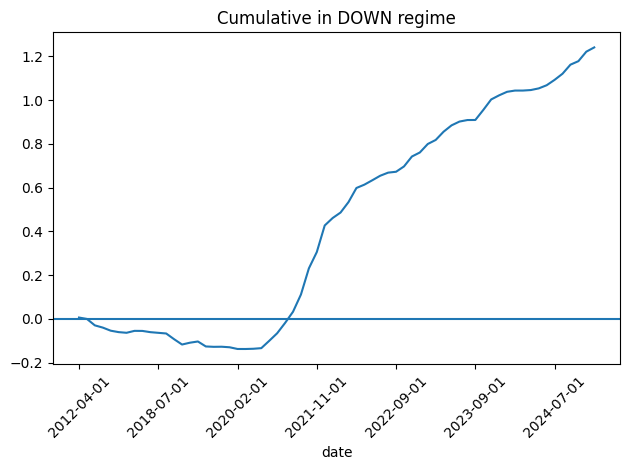

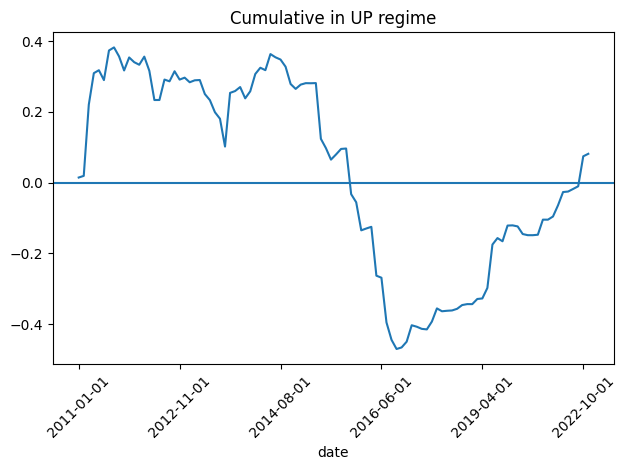

In [19]:
for reg in ["down", "up"]:
    sub = bt[bt["regime"] == reg]
    eq = sub.set_index("date")["ret"].cumsum()
    ax = eq.plot(title=f"Cumulative in {reg.upper()} regime")
    plt.axhline(0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [27]:
# 1️⃣ raw alpha 的方向性 vs 波动性
df.groupby("regime")["alpha_signal"].std()
df["alpha_signal"].abs().groupby(df["regime"]).mean()

# 2️⃣ final signal 的风险结构
df.groupby("regime")["final_signal_used"].std()
df["final_signal_used"].abs().groupby(df["regime"]).mean()

# 3️⃣ IC 对比（核心）
ic_by_regime(df, signal_col="alpha_signal")
ic_by_regime(df, signal_col="final_signal_used")


,ic,positive_ratio,n_obs
regime,,,
down,0.436942,0.742424,66
up,-0.044680,0.558824,102
